In [ ]:
!wget —load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget —quiet —save-cookies ~/cookies.txt —keep-session-cookies —no-check-certificate 'https://docs.google.com/uc?export=download&id=1a9XB3r83ZCFWLOHBp8ooz3zQFl9rEIei' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1a9XB3r83ZCFWLOHBp8ooz3zQFl9rEIei" -O open.zip && rm -rf ~/cookies.txt

--2023-08-13 16:50:39--  http://xn--quiet-3u3b/
Resolving xn--quiet-3u3b (xn--quiet-3u3b)... failed: Name or service not known.
wget: unable to resolve host address ‘xn--quiet-3u3b’
--2023-08-13 16:50:39--  http://xn--save-cookies-w19f/
Resolving xn--save-cookies-w19f (xn--save-cookies-w19f)... failed: Name or service not known.
wget: unable to resolve host address ‘xn--save-cookies-w19f’
/root/cookies.txt: Scheme missing.
--2023-08-13 16:50:39--  http://xn--keep-session-cookies-ou2l/
Resolving xn--keep-session-cookies-ou2l (xn--keep-session-cookies-ou2l)... failed: Name or service not known.
wget: unable to resolve host address ‘xn--keep-session-cookies-ou2l’
--2023-08-13 16:50:39--  http://xn--no-check-certificate-ou2l/
Resolving xn--no-check-certificate-ou2l (xn--no-check-certificate-ou2l)... failed: Name or service not known.
wget: unable to resolve host address ‘xn--no-check-certificate-ou2l’
--2023-08-13 16:50:39--  https://docs.google.com/uc?export=download&id=1a9XB3r83ZCFWLOHBp

In [ ]:
!unzip -qq open.zip

replace image/train/train_104577.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
from google.colab import files
file_uploaded = files.upload()

Saving without_closed_ended_question.csv to without_closed_ended_question.csv


## Import

In [ ]:
!pip install transformers

In [ ]:
import os
import pandas as pd

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models # 이미지
from torchvision import transforms
from PIL import Image

from transformers import GPT2Tokenizer, GPT2Model # 텍스트

from tqdm.auto import tqdm

## Dataset

In [ ]:
class VQADataset(Dataset):
    def __init__(self, df, tokenizer, transform, img_path, is_test=False):
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform
        self.img_path = img_path
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_name = os.path.join(self.img_path, row['image_id'] + '.jpg') # 이미지
        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)

        question = row['question'] # 질문
        question = self.tokenizer.encode_plus(
            question,
            truncation=True,
            add_special_tokens=True,
            max_length=32,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        if not self.is_test:
            answer = row['answer'] # 답변
            answer = self.tokenizer.encode_plus(
                answer,
                max_length=32,
                padding='max_length',
                truncation=True,
                return_tensors='pt')
            return {
                'image': image.squeeze(),
                'question': question['input_ids'].squeeze(),
                'answer': answer['input_ids'].squeeze()
            }
        else:
            return {
                'image': image,
                'question': question['input_ids'].squeeze(),
            }

## Model

In [ ]:
class VQAModel(nn.Module):
    def __init__(self, vocab_size):
        super(VQAModel, self).__init__()
        self.vocab_size = vocab_size

        self.resnet = models.resnet50(pretrained=True)
        self.gpt2 = GPT2Model.from_pretrained('gpt2')
        self.gpt2.resize_token_embeddings(vocab_size) # 추가한 [PAD] 토큰 반영

        combined_features_size = 1000 + self.gpt2.config.hidden_size # resnet 출력 차원 + gpt2 출력 차원
        self.classifier = nn.Linear(combined_features_size, vocab_size)

    def forward(self, images, question):
        image_features = self.resnet(images)
        image_features = image_features.view(image_features.size(0),-1)

        outputs = self.gpt2(question)
        output_features = outputs.last_hidden_state # [batch, sequence, hidden]

        image_features = image_features.unsqueeze(1).expand(-1, output_features.size(1),-1) # [batch, sequence, 1000]

        combined = torch.cat([image_features, output_features], dim=-1) # [batch, sequence, 1000+hidden]
        output = self.classifier(combined) # [batch, vocab_size]
        return output

## DataLoader

In [ ]:
# 데이터 불러오기
train_df = pd.read_csv('train.csv') #without_closed_ended_question 파일로 바꿔서 2번 실험
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
train_img_path = 'image/train'
test_img_path = 'image/test'

# dataset & dataloader
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
vocab_size = len(tokenizer)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = VQADataset(train_df, tokenizer, transform, train_img_path, is_test=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Train & Inference

In [ ]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for data in tqdm(loader, total=len(loader)):
        images = data['image'].to(device)
        question = data['question'].to(device)
        answer = data['answer'].to(device)

        optimizer.zero_grad()

        outputs = model(images, question)

        # output: [batch, sequence, vocab], answer : [batch, sequence]
        loss = criterion(outputs.view(-1, outputs.size(-1)), answer.view(-1))
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(loader)
    return avg_loss

In [ ]:
def inference(model, loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for data in tqdm(loader, total=len(loader)):
            images = data['image'].to(device)
            question = data['question'].to(device)

            outputs = model(images, question) # [batch, sequence, vocab]

            _, pred = torch.max(outputs, dim=2) # values, indices = _, pred
            preds.extend(pred.cpu().numpy())

    return preds

## Run!

In [ ]:
# device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"current device is {device}")

# Model
model = VQAModel(vocab_size).to(device)

# Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Training loop
for epoch in range(2):
    avg_loss = train(model, train_loader, optimizer, criterion)
    print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")
    torch.save({
      'model': model,
      'optimizer': optimizer,
      'epoch': epoch
      }, f'baseline_{epoch+1}.pth') #저장하고 모델이름으로 수정

current device is cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/5618 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.2169


  0%|          | 0/5618 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.1685


  0%|          | 0/5618 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

## Post-Processing

In [ ]:
# Dataset & DataLoader
test_dataset = VQADataset(test_df, tokenizer, transform, test_img_path, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# inference
preds = inference(model, test_loader)

no_pad_output = []
for pred in preds:
    output = pred[pred != 50257] # [PAD] token 제외
    no_pad_output.append(tokenizer.decode(output).strip()) # 토큰 id -> 토큰

  0%|          | 0/633 [00:00<?, ?it/s]

## Submission

In [ ]:
sample_submission['answer'] = no_pad_output
sample_submission.to_csv('submission.csv', index=False)

In [ ]:
submission = pd.read_csv('submission.csv')

In [ ]:
submission

,ID,answer
0,TEST_00000,yes
1,TEST_00001,beach
2,TEST_00002,s
3,TEST_00003,white
4,TEST_00004,no
...,...,...
40474,TEST_40474,black
40475,TEST_40475,b
40476,TEST_40476,yes
40477,TEST_40477,horse


# Custom

In [ ]:
image_path = 'image/test'
image = 'test_00000'
Image.open(f'{image_path}/{image}.jpg').convert('RGB')

current device is cuda
what is her hair color?


  0%|          | 0/1 [00:00<?, ?it/s]

Question:  what is her hair color?
Answer:  to


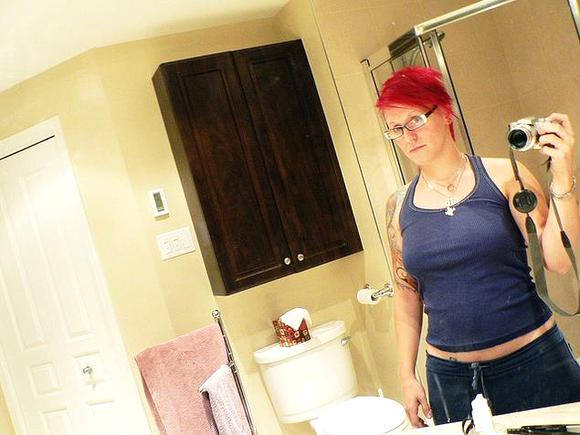

In [ ]:
# device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"current device is {device}")

# Model
checkpoint = torch.load(f'baseline_{epoch+1}.pth') #모델
model = checkpoint['model']
optimizer = checkpoint['optimizer']
epoch = checkpoint['epoch']

question = input()
test_df = pd.DataFrame({"image_id":[image], "question":[question]})

test_dataset = VQADataset(test_df, tokenizer, transform, test_img_path, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
preds = inference(model, test_loader)
for pred in preds:
    output = pred[pred != 50257] # [PAD] token 제외

print('Question: ',question)
print('Answer: ', tokenizer.decode(output).strip()) # 토큰 id -> 토큰
Image.open(f'{image_path}/{image}.jpg').convert('RGB')